# Read in Data

In [47]:
import os
import pandas as pd
import numpy as np
import xgboost
import multiprocessing
from collections import defaultdict

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer

import gensim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv("../input/train_v2.csv")
test_data = pd.read_csv("../input/test_v2.csv")

In [3]:
train_data.head(1)

,article_id,title,url,publisher,hostname,timestamp,category
0,1,Forex - Pound drops to one-month lows against ...,http://www.nasdaq.com/article/forex-pound-drop...,NASDAQ,www.nasdaq.com,1.390000e+12,4


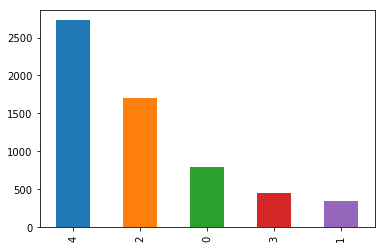

In [4]:
train_data.category.value_counts().plot('bar')

# Housekeeping

In [5]:
def stem(sent, stemmer_type='porter'):
    '''
    stemmer_type can be porter, lancaster, or snowball
    '''
    if stemmer_type == 'porter':
        stemmer = PorterStemmer()
    elif stemmer_type == 'lancaster':
        stemmer = LancasterStemmer()
    else:
        stemmer = SnowballStemmer('english')
    
    words = gensim.utils.simple_preprocess(sent)
    return ' '.join([stemmer.stem(word) for word in words])

In [6]:
def lemmatize(sent):
    lemmatizer = WordNetLemmatizer()
    
    words = gensim.utils.simple_preprocess(sent)
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

In [7]:
train_data["title"][1]

'Hertz to Exit Equipment Rental Business in $2.5B Spinoff'

In [8]:
train_data["title"].apply(stem)[1]

'hertz to exit equip rental busi in spinoff'

In [9]:
# perform stemming
train_data.loc[:, "title"] = train_data["title"].apply(stem)
test_data.loc[:, "title"] = test_data["title"].apply(stem)

In [10]:
# X_train, X_test, Y_train, Y_test = train_test_split(train_data["title"], train_data["category"], test_size = 0.2)
# X_train = np.array(X_train)
# X_test = np.array(X_test)  # indeed X_valid is a more accurate name
# Y_train = np.array(Y_train)
# Y_test = np.array(Y_test)  # indeed Y_valid is a more accurate name

In [11]:
def train_model(classifier, feature_vector_train, label_train, feature_vector_valid, label_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return {'accuracy': accuracy_score(label_valid, predictions), 
            # 'f2_seperate': fbeta_score(Y_test, Y_predict, average=None, beta=2),
            'f2_macro': fbeta_score(label_valid, predictions, average='macro', beta=2),
            'f2_micro': fbeta_score(label_valid, predictions, average='micro', beta=2),
            'f2_weighted': fbeta_score(label_valid, predictions, average='weighted', beta=2)}

In [12]:
def cross_validation_data(train_data):
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    for train_index, test_index in sss.split(train_data["title"], train_data["category"]):
        X_train, X_test = train_data["title"][train_index], train_data["title"][test_index]
        Y_train, Y_test = train_data["category"][train_index], train_data["category"][test_index]
        yield X_train, Y_train, X_test, Y_test

In [13]:
# # Not performing well
# def random_sample(X, y, method='RandomOverSampler'):
#     if method == 'RandomOverSampler':
#         sampler = RandomOverSampler()
#     elif method == 'RandomUnderSampler':
#         sampler = RandomUnderSampler()
#     elif method == 'ADASYN':
#         sampler = ADASYN()
#     elif method == 'SMOTE':
#         sampler = SMOTE()

#     return sampler.fit_sample(X, y)

In [14]:
# le_hostname = preprocessing.LabelEncoder()
# le_hostname.fit_transform(train_data['hostname']).shape

# le_publisher = preprocessing.LabelEncoder()
# le_publisher.fit_transform(train_data['publisher'].fillna('UNKNOWN'))

In [28]:
cores = multiprocessing.cpu_count()

In [11]:
GLOVE_PATH = "glove.6B.50d.txt"

with open(GLOVE_PATH, "rb") as lines:
    w2v_glove = { line.split()[0].decode("utf-8"): np.array(line.split()[1:],dtype=np.float32) for line in lines }

In [15]:
X, y = [], []

for text, label in zip(train_data["title"], train_data["category"]):
    X.append(text.split())
    y.append(label)

X, y = np.array(X), np.array(y)

In [21]:
X_test = []

for text in test_data["title"]:
    X_test.append(text.split())

X_test = np.array(X_test)

In [24]:
X_all = np.concatenate([X, X_test])

In [114]:
word2vec_model = gensim.models.Word2Vec(X_all, size=50, window=5, min_count=1, workers=cores)

In [115]:
w2v = { w: vec for w, vec in zip(word2vec_model.wv.index2word, word2vec_model.wv.vectors) }

In [119]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(w2v_glove))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(w2v_glove))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(ngram_range=(1,2), 
                                max_df=1.0,
                                min_df=1,
                                max_features=4000, 
                                analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [120]:
mean_emb_etree = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                           ("extra trees", ExtraTreesClassifier(n_estimators=180, criterion='entropy'))])
tfidf_emb_etree = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                            ("extra trees", ExtraTreesClassifier(n_estimators=180, criterion='entropy'))])

mean_emb_rf = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("random forest", RandomForestClassifier(n_estimators=180, criterion='entropy'))])
tfidf_emb_rf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                         ("random forest", RandomForestClassifier(n_estimators=180, criterion='entropy'))])

mean_emb_svc = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                          ("svc", SVC(kernel='linear'))])
tfidf_emb_svc = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                          ("svc", SVC(kernel='linear'))])

In [121]:
models = [
    ("mean_emb_etree", mean_emb_etree),
    ("tfidf_emb_etree", tfidf_emb_etree),
    ("mean_emb_etree", mean_emb_rf),
    ("tfidf_emb_rf", tfidf_emb_rf),
    ("mean_emb_svc", mean_emb_svc),
    ("tfidf_emb_svc", tfidf_emb_svc)
]

In [122]:
scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in models]
print(scores)

KeyboardInterrupt: 